# Imports and Setup

First of all, we need to import all libraries needed to create a Hierarchical Cluster. After that, we have to read the files with the product names and shortname products.

In [148]:
import seaborn as sns
import random
import matplotlib.pyplot as plt
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import dendrogram, fcluster, set_link_color_palette
from sklearn.metrics.cluster import adjusted_rand_score
from collections import defaultdict, Counter
from matplotlib.colors import rgb2hex, colorConverter
from copy import deepcopy
from itertools import chain

In [149]:
# get all product name of file and store in a list
prod_names = open('Datasets/tests/products_name').read().split('\n')

# get all shortname of file and store in a list
shortname_list = open('Datasets/tests/shortnames').read().split('\n')

correct_shortname = open('Datasets/tests/correct_shortnames').read().split('\n')

# some setting for this notebook to actually show the graphs inline
%matplotlib inline
np.set_printoptions(precision=3, suppress=True) # suppress scientific float notation

##### Here, we define all parameters required to generate the clustering process

In [150]:
sample = 50 

prod_names = prod_names[:sample]
shortname_label = shortname_list[:sample] 
correct_shortname = correct_shortname[:sample]

n = len(correct_shortname) # number of elements in the dataset

human_interactions = int(n) # number of desired interactions by the user

num_pool_pairs = 3 # defines the number of pool of pairs

dist_thres = 1 # indicates the distance threshold

# Generating Sample Data

In this step, we are generating a Tf-IDF matrix with respect to the product names. The distance metric used is the cosine distance.

In [151]:
# generating a tf-idf matrix with respect to the given dataset
tfidf_vectorizer = TfidfVectorizer(input=prod_names) # define vectorizer parameters
tfidf_matrix = tfidf_vectorizer.fit_transform(prod_names) # fit the vectorizer to product name
dist = 1 - cosine_similarity(tfidf_matrix) # getting the cosine distance of the tf-idf matrix

# print the shape of the tf-idf matrix. 
print "TF-IDF Matrix Shape: %s" % [tfidf_matrix.shape] # return (x, y) where x is num of sample and y is num of terms

TF-IDF Matrix Shape: [(50, 443)]


# Updating the TF-IDF Matrix
Here we update the tf-idf matrix. For labels with same shortname we update the distance (subtracting by 2). 

In [152]:
"""
 Reduce the distance matrix where the labels have the same name
 Args:
     shortname_label -> shortnames of the products
     dist -> distance matrix
 Return:
     The distance matrix updated
"""
def reduce_dist_same_shortnames(shortname_label, dist):
    sn_array = np.asarray(shortname_label)
    many_sn = {}
    for i,el in enumerate(sn_array):
        same_sn_idx = np.where(sn_array==el)[0] 
        dist[i][i] = 0
        if len(same_sn_idx) > 1 and el not in many_sn.keys():
            many_sn[el] = same_sn_idx
    
    for sn_idx in many_sn.values():
        for v in sn_idx:
            for j in sn_idx[np.where(sn_idx==v)[0][0]+1:]: 
                if np.where(sn_idx==v)[0] != np.where(sn_idx==j)[0]:
                    dist[v][j] = dist[v][j]/2
                    dist[j][v] = dist[j][v]/2
    return dist

dist = reduce_dist_same_shortnames(shortname_label, dist)      

# Threshold Calibration

In this section, we defined a calibration procedure to estimate the confidence value. At each step, the confidence value is calculated according to the difference between the two shortest distances in the matrix. At the end, the values are sorted and an adequate threshold value is selected with respect to the number of human interactions *q*. We used the unsupervised clustering to update the matrix, with single linkage method.


In [153]:

"""
 Cluster class to merge one cluster into another.
 The __repr__ method returns a printable representation of the cluster.
 Args:
     clusters -> the shortnames of the products
     grid -> the distance matrix
     lefti -> the left cluster to be merged
     righti -> the right cluster to be merged
 Return:
     (updated cluster, updated distance matrix)
"""
class Cluster:
    def __init__(self):
        pass
    def __repr__(self):
        return '(%s,%s)' % (self.left, self.right)
    def add(self, clusters, grid, lefti, righti):
        self.left = clusters[lefti]
        self.right = clusters[righti] 
        
        # merge column righti into lefti, getting the min value btw them
        for r in grid:
            r[lefti] = min(r[lefti], r[righti])
        grid = np.delete(grid, righti, 1) # delete the righti column
        # merge row righti into lefti, getting the min value btw them
        grid[lefti] = map(min, zip(grid[lefti], grid[righti]))
        grid = np.delete(grid, righti, 0) # delete the righti row
        
        # delete cluster righti from the clusters
        clusters.pop(righti)
   
        return (clusters, grid)

"""
 Helper function
 Args:
     grid -> array of the matrix in the given step
 Return:
      (minimum distance index, minimum distance value)
"""
def get_mindist(grid):
    distances = [] # distance -> (row, column, distance)
    try:
        # get the first index of distance in column 0, where distance is greater than 0     
        idx = next(r for r in grid[:, 0] if r > 0 )
        idx = np.where(grid[:, 0] == idx)[0][0]
    except StopIteration:
        return (0, 0, 0)     

    # get the distance for pairs
    for i,row in enumerate(grid[idx:]): 
        distances += [(i+idx, j, c) for j,c in enumerate(row[:i+idx])] # for each pair store the distance

    #get the closest pair
    mindist = min(distances, key=lambda x:x[2])
    
    return mindist

"""
 Get the nearest pair of elements in a given step. 
 Args:
     array of matrix in the given step 
     idx_list is a list with all indices, where mindist_indice not in idx_list
 Return: 
     (minimum distance value, minimum distance index)
"""
def compute_mindist(grid):
    # get the shortest indice of the given step
    i, j, d = get_mindist(grid)
    mindist_value = d 
    mindist_indice = (min(i, j), max(i, j))
    return mindist_value, mindist_indice

"""
 Get the nearest pair of elements with respect to one element of the merged cluster in a given step
 Args:
     matrix is the distance matrix
     idx_list is a list with all indices, where:
         secmindist_indice not in idx_list 
         secmindist_indice in {a,b} or secmindist_indice in {a,b}
 Return:
     (second minimum distance, second minimum indice, pair indice) 
"""
def compute_secmindist(matrix, idx_list):
    
    array_i = matrix[idx_list[0]]
    mask = np.ones((len(array_i),), dtype=bool)
    mask[idx_list[1]] = 0
    mask[idx_list[0]] = 0
    mindist_i = min(np.asarray(array_i)[mask])

    array_j = matrix[idx_list[1]]
    mask = np.ones((len(array_j),), dtype=bool)
    mask[idx_list[0]] = 0
    mask[idx_list[1]] = 0
    mindist_j = min(np.asarray(array_j)[mask])

    d, i, j = min((mindist_i, np.where(array_i==mindist_i)[0][0], idx_list[0]), (mindist_j, np.where(array_j==mindist_j)[0][0], idx_list[1]))
    secmindist_value = d
    secmindist_indice = (min(i, j), max(i, j))
    return secmindist_value, secmindist_indice


"""
 Get a confidence threshold value with respect to the desired number of interactions.
 Args:
     dist -> distance matrix
     n -> length of the dataset
     q -> desired number of human interactions
 Return:
     confidence threshold value
"""
def threshold_calibration(dist, n, q):
    grid = deepcopy(dist)
    label = deepcopy(shortname_label)
    # vector which stores the confidence value for each element 
    confidence_list = []

    # for each element, calculate the confidence value
    for k in range(n-1):
        mindist_val, mindist_ind = compute_mindist(grid) # get the shortest distance
        if k+2 >=n:
            confidence_list.append(mindist_val)
        else:             
            secmindist_val, secmindist_ind = compute_secmindist(grid, mindist_ind) # get the second shortest distance
            confidence_list.append(abs(secmindist_val - mindist_val)) # calculate the confidence value, by the diff btw distances

        c = Cluster()
        _, grid = c.add(label, grid, mindist_ind[0], mindist_ind[1])
        
        
    confidence_list.sort() # sort the confidence list 
    conf_threshold = confidence_list[q] if q < n else confidence_list[n-2] # get the confidence threshold value

    #print confidence_list # Just to show all the confidence_list
    return conf_threshold

%time threshold = threshold_calibration(dist, n, human_interactions)
print "\nConfidence Threshold Value: %s" % (threshold)

CPU times: user 99.4 ms, sys: 4.1 ms, total: 104 ms
Wall time: 90.2 ms

Confidence Threshold Value: 1.0


# Pool of Cluster Pairs

Here, we created a function to show for the user a pool of cluster pairs to be merged when a low confidence is detected. This low confidence is detected if the distance of the pair is smaller than the threshold value. So, a pool of pairs of clusters is presented to the user in order to choose the pair that corresponds to the best merge. The steps to get it is:

- Find the best merge with the shortest distance (i, j), at the given step.
- Find other possible clusters, c-1, involving i or j. The variable c is the size of the pool of clusters.

In [154]:
"""
 Get the nearest pair of elements with respect to one element of the merged cluster
 in a given step that is not in idx_dict
 Args:
     grid -> distance matrix
     i -> idx i of the min_dist
     j -> idx j of the min_dist
     idx_list is a list with all indices, where:
         secmindist_indice not in idx_list 
         secmindist_indice in {a,b} or secmindist_indice in {a,b}
 Return:
     (second minimum distance, second minimum index, all idx pairs) 
"""
def compute_c_mindist(grid, i, j, idx_dict):
    array_i = grid[i]
    array_j = grid[j]
    mask_i = np.ones((len(array_i),), dtype=bool)
    mask_j = np.ones((len(array_j),), dtype=bool)
    for key,val in idx_dict.items():
        if key == i:
            for v in val:
                mask_i[v] = 0
        elif key == j:
            for v in val:
                mask_j[v] = 0
    mindist_i = min(np.asarray(array_i)[mask_i])
    mindist_j = min(np.asarray(array_j)[mask_j])
    
    sec_i = [x for x in np.where(array_i==mindist_i)[0] if x not in idx_dict[i]]
    sec_j = [x for x in np.where(array_j==mindist_j)[0] if x not in idx_dict[j]]
    
    d, secon, princ = min((mindist_i, sec_i[0], i), (mindist_j, sec_j[0], j))
    secmindist_value = d
    secmindist_indice = (princ, secon)
    idx_dict[princ].append(secon)
    return secmindist_value, secmindist_indice, idx_dict
    
"""
 Get a pool of pairs of the given matrix
 Args:
     shortname_label -> shortname list of the dataset
     dist -> the distance matrix 
     c -> size of the pool of the clusters
 Return:
     pool of cluster pairs, like:
     [((shortname1, idx1), (shortname2, idx2), distance12),
      ((shortname3, idx3), (shortname4, idx4), distance34)]
"""  
def cluster_pairs(shortname_label, dist, c):
    pool = []  # list with pool of cluster pairs on the k-th iteration
    n_singletons = len(shortname_label) # number of clusters 
    all_idx = defaultdict(list) # list to add all indices from the compute_secmindist function
    
    # get the two nearest clusters in the given step
    mindist_val, mindist_ind = compute_mindist(dist)
    
    all_idx[mindist_ind[0]] = [mindist_ind[0], mindist_ind[1]]    
    all_idx[mindist_ind[1]] = [mindist_ind[0], mindist_ind[1]]    

    # add a possible cluster merge in pool -> ((shortname_x, idx_x),(shortname_y, idx_y), d_xy)
    pool.append( ( (shortname_label[mindist_ind[0]], mindist_ind[0]), (shortname_label[mindist_ind[1]], mindist_ind[1]), mindist_val ) )

    # get c pool of clusters  
    for i in range(1, c if c < n_singletons else n_singletons-1):
        secmindist_val, secmindist_ind, all_idx = compute_c_mindist(dist, mindist_ind[0], mindist_ind[1], all_idx)
        i = secmindist_ind[0]
        j = secmindist_ind[1]
        pool.append(((shortname_label[i], i), (shortname_label[j], j), secmindist_val))

    return pool

# Perform HCAC

Now, we build a Semi-Supervised Agglomerative Clustering. Then, a 4 by (n−1) matrix Z is returned. At the i-th iteration, clusters with indices Z[i, 0] and Z[i, 1] are combined to form cluster n+i. A cluster with an index less than n corresponds to one of the n original observations. The distance between clusters Z[i, 0] and Z[i, 1] is given by Z[i, 2]. The fourth value Z[i, 3] represents the number of original observations in the newly formed cluster. This matrix Z is necessary to plot a dendogram. The step-by-step to generate the cluster is:

* Repite:
    1. Find the indices of the lower-triangle of the matrix which has the two shortest distance.
    2. If: 
          * confidence value (difference between two shortest distance) < threshold confidence value
          * names of the products are different
          * two shortest distances < 1
          * names of the products aren't in the same group of incorrect products   
         Then: show a pool of pairs of clusters. (*cluster_pairs function*) 
    3. Add the selected cluster, merging the right column to the left column, keeping the minimum distance between them, and deleting the right column after that. Does the same for the rows, and return the updated distance matrix and the updated clusters' name.
    4. Add the info of the merged clusters into the matrix Z.
* While clusters > 1


In [155]:
"""
 Helper function to merge groups based on intersections
 Args:
     lsts -> list of clusters list that cannot merge
 Return:
     List of clusters list merged by intersections
"""
def update_cannot_link(lsts):
    sets = [set(lst) for lst in lsts if lst]
    merged = True
    while merged:
        merged = False
        results = []
        while sets:
            common, rest = sets[0], sets[1:]
            sets = []
            for x in rest:
                if x.isdisjoint(common):
                    sets.append(x)
                else:
                    merged = True
                    common |= x
            results.append(common)
        sets = results
    return sets

"""
 Add the clusters that cannot merge in a list.
 Args:
     pair_list -> pool of pairs shown to the user
     cannot_list -> list of clusters list that cannot merge
 Return:
     Use the Helper function to update the cannot_list.
"""
def add_cannot_link_clusters(pair_list, cannot_list):
    for pair in pair_list:
        for group in sorted(cannot_list):
            if set(group).issubset(set(pair[1][0] + pair[0][0])):
                cannot_list.remove(group)
        cannot_list.append(list(set(pair[0][0] + pair[1][0])))
    return update_cannot_link(cannot_list)
        
"""
 Get the highest distance
 Args:
     grid -> distance matrix
 Return:
     the maximum distance pair & value
"""
def get_maxdist(grid):
    distances = [] # distance -> (distance)
    try:
        # get the first index of distance in column 0, where distance is greater than 0     
        idx = next(r for r in grid[:, 0] if r > 0 )
        idx = np.where(grid[:, 0] == idx)[0][0]
    except StopIteration:
        return (0, 0, 0)     

    # get the distance for pairs
    for i,row in enumerate(grid[idx:]): 
        distances += [c for j,c in enumerate(row[:i+idx])] # for each pair store the distance
    
    #get the highest pair
    maxdist = max(distances)
    
    return maxdist

"""
 Get the best cluster merge at each step, adding the info in the matrix Z.
 Args:
     labels, list of the shortnames
     grid, the distance matrix
 Return:
     Matrix Z, with 4 columns and n-1 rows, where:
         column 1 and 2 are the merged clusters
         column 3 is the distance between the merged clusters
         column 4 is the number of original observations in the newly formed cluster
"""
def agglomerate(labels, grid):
    
    print ("\n*** Welcome to the Semi-Supervised Agglomerative Clustering ***\n")
    
    clusters = deepcopy(labels)
    counter = 0 # used to define the indice in matrix Z
    z_distance = 0 # used to add all distances of the merged cluster
    Z = np.zeros((n - 1, 4)) # Z matrix initialized with zeros
    dict_elements = { i:[i] for i in range(n)} # dict with idx of matrix as key and number of pairs as value 
    idx_list = [[i] for i in range(n)] # list with the indices of the clusters
    labels_list = [[l] for l in labels] # list with the shortnames of the clusters
    cannot_link = [] # list of tuple with clusters that cannot merge
    num_questions=0 # indicates the number of questions asked to the user
    canlink=0 # indicates the number of correct clusters 
    
    # get the highest distance
    maxd = get_maxdist(grid)
        
    merged_answer = 0 # indicates the merged answers
    unmerged_answer = 0 # indicates the unmerged answers

    while len(clusters) > 1:
        can_merge = True
        is_std_dist = True
        correct_choice = False 

        # get the closest pair
        d,(i,j) = compute_mindist(grid)
                
        # get the second closest pair and do the diff btw them to get the confidence_value
        d2 = 0
        if len(grid) > 2:
            d2, _ = compute_secmindist(grid,(i,j))
        confidence_value = abs(d2 - d)   
        
        # Here we look if the min pair is an incorrect cluster  & distances < dist_thres.
        # if its we update the distance matrix and dont merge anything in this step.
        for cl in cannot_link:
            if (cl.issubset(set(labels_list[i] + labels_list[j])) or
               set(labels_list[i] + labels_list[j]).issubset(cl)) and d < dist_thres and d2 < dist_thres and not (set(labels_list[j]) & set(labels_list[i])):
                grid[i][j] = d + maxd 
                grid[j][i] = d + maxd
                is_std_dist = False
                can_merge = False
                break
        
        # if distance is lower than threshold and shortnames are different, then get pool of pairs.
        if confidence_value <= threshold and d < dist_thres and d2 < dist_thres and is_std_dist and not (set(labels_list[j]) & set(labels_list[i])): 
            pool_list = cluster_pairs(labels_list, grid, num_pool_pairs + len(cannot_link))
            
            # remove incorrect clusters from the pool of pairs list
            for pl in pool_list:
                if pl[2] > 1:
                    pool_list.remove(pl)
            
            pool_list = pool_list[:num_pool_pairs]

            if len(pool_list) > 0:
                num_questions+=1
                while not correct_choice:
                    print ("\n ------------------------------------------------------------ \n")
                    choices = []
                    print ("Choose the best pairwise below:")
                    for ind, pair in enumerate(pool_list):
                        first_pair = dict(Counter(pair[0][0]))
                        second_pair = dict(Counter(pair[1][0]))
                        print("%s - %s x %s" % (ind, first_pair, second_pair))
                        choices.append(ind)
                    print("%s - None of the above" % len(pool_list))
                    choices.append(len(pool_list))

                    choose = raw_input("Type the number here: ")
                    correct_choice = (True if int(choose) in choices else False) if choose.isdigit() else False
                choose = int(choose)        
                if not (choose == len(pool_list)):
                    merged_answer += 1
                    j, i, d = (pool_list[choose][0][1], pool_list[choose][1][1], pool_list[choose][2])
                else:
                    unmerged_answer += 1
                    
                    # add all pairs of pool_list to cannot_link
                    cannot_link = add_cannot_link_clusters(pool_list, cannot_link)
                    
                    #print cannot_link
                    for pair in pool_list:
                        grid[pair[0][1]][pair[1][1]] = pair[2] + maxd 
                        grid[pair[1][1]][pair[0][1]] = pair[2] + maxd
                    d = pair[2] + maxd
                    can_merge = False         
            
        if can_merge:
             
            # if distances is lower than dist_thres
            if d < dist_thres and d2 < dist_thres:
                canlink+=1                   
                       
            i, j = (min(i,j), max(i,j)) # just to make sure i is left column, j is the right column

            # get values to Z
            c1 = next(k for k,v in dict_elements.iteritems() if idx_list[i] == v) 
            c2 = next(k for k,v in dict_elements.iteritems() if idx_list[j] == v) 
            num_original_clusters = len(dict_elements.get(c1)) + len(dict_elements.get(c2))
            z_distance += abs(d)
            idx_list[i] += idx_list.pop(j) # merge j into i, and delete j
            # add values to Z
            Z[counter] = [c1, c2, z_distance, num_original_clusters] 
            counter+=1
            # add new cluster into dict_elements
            dict_elements[len(dict_elements)] = dict_elements.get(c1) + dict_elements.get(c2)
            # turn the value of the old clusters(c1, c2) unusable
            dict_elements[c1] = [None] 
            dict_elements[c2] = [None] 

            # merge i<-j
            c = Cluster()
            clusters, grid = c.add(clusters, list(grid), i, j)
            clusters[i] = str(c)
            # update labels list
            labels_list[i] += labels_list.pop(j)
    
    must_link = canlink
    
    print "\n Number of clusters that can link: %s "% canlink
    print " Len of Z: %s"% len(Z)
    print "\n\n Number of Merged Clusters by the User: %s" % merged_answer
    print " Number of Unmerged Clusters by the User: %s" % unmerged_answer
    print "\n Total Questions: %s\n" % num_questions
    cut_off = Z[must_link-1:must_link, 2][0] + 0.1
    return Z, cut_off, must_link

%time Z, cut_off, must_link = agglomerate(shortname_label, dist)




*** Welcome to the Semi-Supervised Agglomerative Clustering ***


 ------------------------------------------------------------ 

Choose the best pairwise below:
0 - {'prateleira': 1} x {'escrivaninha': 1}
1 - {'prateleira': 1} x {'sapateira': 1}
2 - {'escrivaninha': 1} x {'sapateira': 1}
3 - None of the above
Type the number here: 3

 ------------------------------------------------------------ 

Choose the best pairwise below:
0 - {'smartphone': 8} x {'tablet': 5}
1 - {'smartphone': 8} x {'iphone': 1}
2 - {'tablet': 5} x {'notebook': 1}
3 - None of the above
Type the number here: 1

 ------------------------------------------------------------ 

Choose the best pairwise below:
0 - {'smartphone': 8, 'iphone': 1} x {'tablet': 5}
1 - {'tablet': 5} x {'notebook': 1}
2 - {'tablet': 5} x {'camera': 3}
3 - None of the above
Type the number here: 3

 ------------------------------------------------------------ 

Choose the best pairwise below:
0 - {'armario': 1} x {'sapateira': 1}
1 - {'sap

# Plotting a Dendrogram

Here, we are plotting a dendogram with respect to the matrix Z computed above. The x-axis is the product name, the y-axis is the distance and the labels are the shortnames.

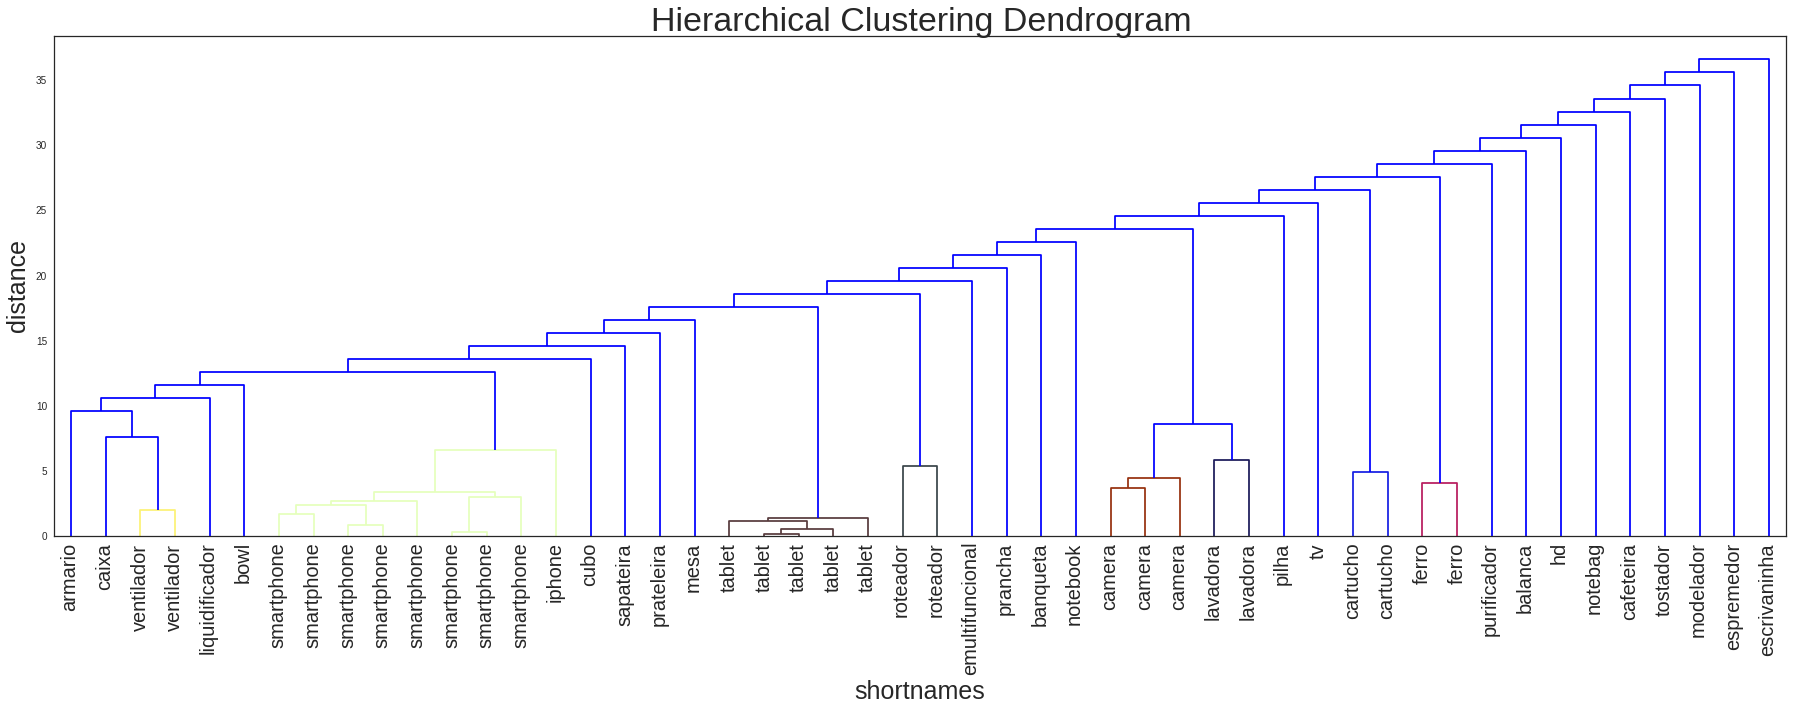

In [156]:
# Generate the colors for all clusters
colors = []
while len(colors) < must_link:
    r = lambda: random.randint(0,255)
    hexcode = ('#%02X%02X%02X' % (r(),r(),r()))
    if hexcode not in colors:
        colors.append(hexcode)

sns.set_palette(colors)
palette = sns.color_palette()
set_link_color_palette(map(rgb2hex, palette))
sns.set_style('white')

# calculate full dendrogram
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram',  fontsize=34)
plt.xlabel('shortnames',  fontsize=25)
plt.ylabel('distance',  fontsize=25)
den = dendrogram(
        Z,
        leaf_rotation=90.,  # rotates the x axis labels
        leaf_font_size=20.,  # font size for the x axis labels
        labels= shortname_label,
        color_threshold = cut_off 
    )

plt.tight_layout()
plt.savefig('ss_hierarchical.png', dpi=200); # save figure

# Selecting a Distance Cut-Off
We use the cut-off computed in the clustering process to ignore the merged clusters above the line, plotting a new dendogram.

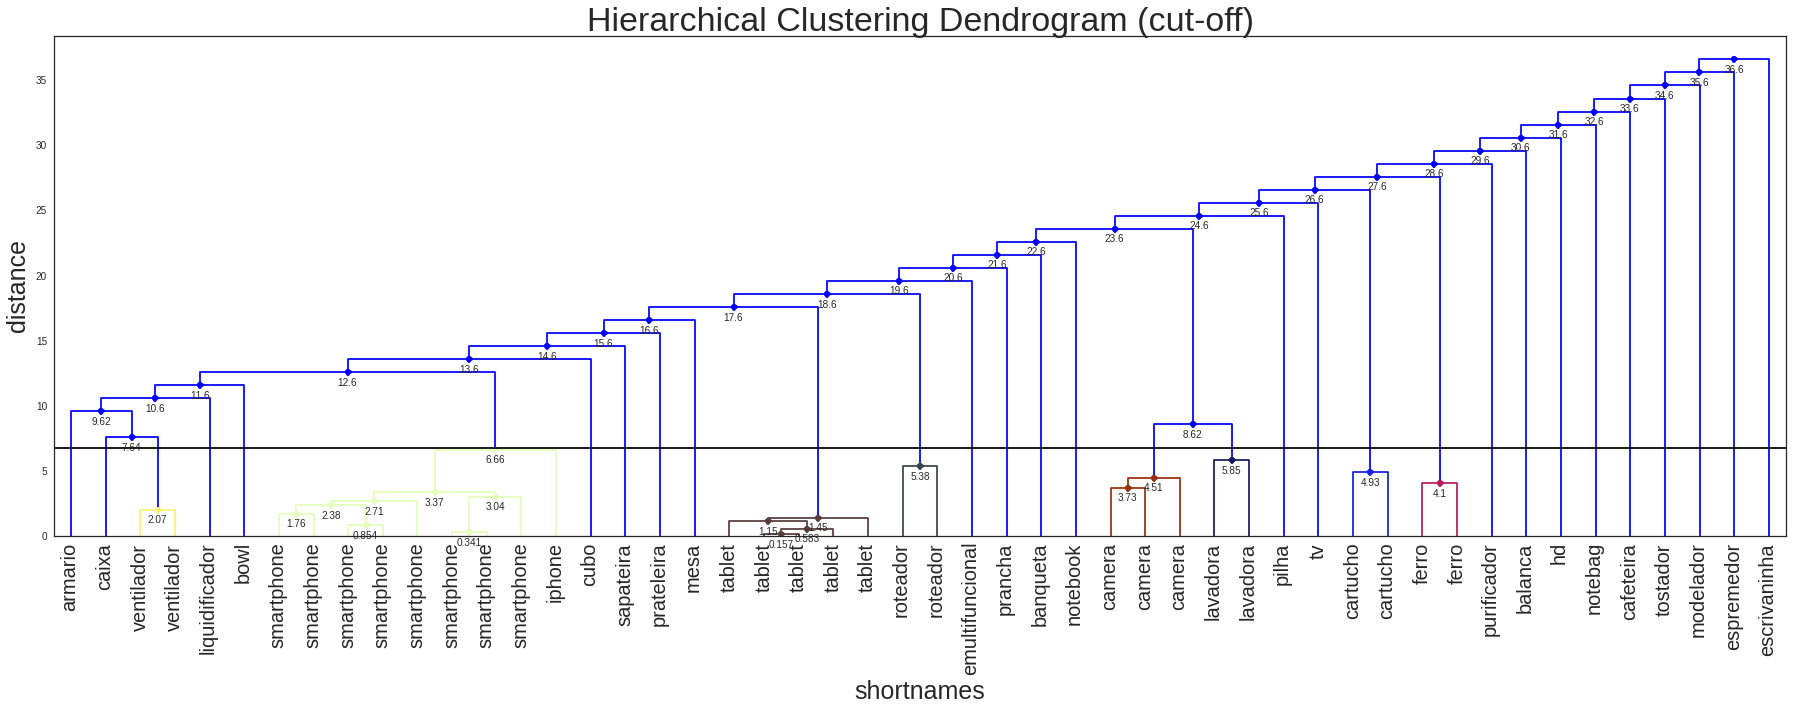

In [157]:
def cutoff_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (cut-off)', fontsize=34)
        plt.xlabel('shortnames', fontsize=25)
        plt.ylabel('distance', fontsize=25)
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

# set cut-off to 1.2 to get 4 final clusters
max_d = cut_off  # max_d as in max_distance
plt.figure(figsize=(25, 10))

cutoff_dendrogram(
    Z,
    #truncate_mode='level',  
    #p=10,  
    show_leaf_counts=False,  
    leaf_rotation=90.,
    leaf_font_size=20.,
    #show_contracted=True,
    #annotate_above=10,
    max_d=max_d,  # plot a horizontal cut-off line
    labels = shortname_label
)

plt.tight_layout()
plt.savefig('ss_hierarchical_cutoff.png', dpi=200); # save figure

# Generating Clusters List
In this step, we generate the representation of the clusters in the dendrogram

In [158]:
pred_clusters = defaultdict(list)
class gen_clusters_colors(dict):
    def _repr_html_(self):
        html = '<table style="border: 0;">'
        for c in self:
            groups = Counter(repr(self[c]).replace('[', '').replace(']','').replace(',','').replace("'",'').split())
            groups_name =[mc[0] for mc in groups.most_common()]
            sn = groups.most_common(1)[0][0].split('_')[0]
            if set(groups_name) & set(correct_shortname):
                c_label = correct_shortname[shortname_label.index(sn)]
            else:
                c_label = sn        
            if c is not 'b':
                hx = rgb2hex(colorConverter.to_rgb(c))
                html += '<tr style="border: 0;">' \
                '<td style="background-color: {0}; ' \
                           'border: 0;">' \
                '<code style="background-color: {0};">'.format(hx)
                html += c_label + '</code></td>'
                html += '<td style="border: 0"><code>' 
                html += str(dict(groups)) + '</code>'
                html += '</td></tr>'
                pred_clusters[c_label].append(sum(dict(groups).values()))
            else:
                for k,v in groups.items():
                    pred_clusters[k].append(v)
        html += '</table>'
        
        return html
    
def get_cluster_classes(den, label='ivl'):
    cluster_idxs = defaultdict(list)
    for c, pi in zip(den['color_list'], den['icoord']):
        for leg in pi[1:3]:
            i = (leg - 5.0) / 10.0
            if abs(i - int(i)) < 1e-5:
                cluster_idxs[c].append(int(i))
    
    vals = list(chain(*[v for k,v in cluster_idxs.items() if k != 'b']))
    for el in cluster_idxs['b']:
        if el in vals:
            cluster_idxs['b'].remove(el)
    for k,v in cluster_idxs.items():
        cluster_idxs[k] = list(set(v))
        
    cluster_classes = gen_clusters_colors()
    for c, l in cluster_idxs.items():
        i_l = [den[label][i] for i in l]
        cluster_classes[c] = i_l
    return cluster_classes


get_cluster_classes(den)

roteador,{'roteador': 2}
ventilador,{'ventilador': 2}
tablet,{'tablet': 5}
camera,{'camera': 3}
ferro,{'ferro': 2}
lavadora,{'lavadora': 2}
smartphone,"{'smartphone': 8, 'iphone': 1}"
cartucho,{'cartucho': 2}


#  Clustering Evaluation
At the end, we evalute the precision of the clustering using the adjusted rand index.

In [159]:
cluster_dict = dict()

for i in range(0, must_link):
    new_cluster_id = n+i
    old_cluster_id_0 = Z[i, 0]
    old_cluster_id_1 = Z[i, 1]
    combined_ids = list()
    if old_cluster_id_0 in cluster_dict:
        combined_ids += cluster_dict[old_cluster_id_0]
        del cluster_dict[old_cluster_id_0]
    else:
        combined_ids += [old_cluster_id_0]
    if old_cluster_id_1 in cluster_dict:
        combined_ids += cluster_dict[old_cluster_id_1]
        del cluster_dict[old_cluster_id_1]
    else:
        combined_ids += [old_cluster_id_1]
    cluster_dict[new_cluster_id] = combined_ids

clusters_id = []
for i in range(0, n):
    clusters_id.append(i)
for c in cluster_dict:
    for item in cluster_dict[c]:
        clusters_id[int(item)] = c
        

print ("Precision of the clustering process is: %s" % adjusted_rand_score((correct_shortname), (clusters_id))) 

Precision of the clustering process is: 1.0
